Testing Curvenlinops for the calculation of: 
 
 $\alpha^*=\frac{-d^{\top} g}{d^{\top} H d}$

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.nn.utils import vector_to_parameters  # this is NOT inverse of params_to_vector, see cell below
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from warnings import warn
import matplotlib.pyplot as plt
import numpy as np
from tueplots import axes, bundles, fonts, fontsizes, figsizes  # for consistent plotting

from curvlinops import GGNLinearOperator, HessianLinearOperator
from curvlinops.examples.functorch import functorch_ggn, functorch_hessian
from curvlinops.examples.utils import report_nonclose
from source.plotting import plot_data, get_style



# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [2]:
# Load the jmlr2001 style
# jmlr_style = bundles.jmlr2001()

In [22]:


"""

# Modify the LaTeX preamble to use Latin Modern fonts
jmlr_style["text.usetex"] = True
jmlr_style["text.latex.preamble"] = r"\usepackage{lmodern}"

# Update font settings
jmlr_style.update({
    'font.size': 15,                # General font size in plots
    'axes.labelsize': 16,           # Axis label size
    'legend.fontsize': 16,          # Legend font size
    'xtick.labelsize': 13,          # X-tick font size
    'ytick.labelsize': 13,          # Y-tick font size
    'axes.titlesize': 15,           # Title size
})

# Define custom figure size for DIN A4 margins

jmlr_style.update({
    # 'figure.figsize': (5.5, 8),  # Usable dimensions in inches
    'figure.constrained_layout.use': True,
    'figure.autolayout': False,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.015,
})



plt.rcParams.update({"figure.dpi": 600})  # Set to 300 for high resolution

"""



    
    


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 127-128: truncated \uXXXX escape (149105503.py, line 1)

Defining the method for vector -> Parameter list (iterable):

In [2]:
def vector_to_parameter_list(vec, parameters):
    """Convert the vector `vec` to a parameter-list format matching
    `parameters`. This function is the inverse of `parameters_to_vector` from
    `torch.nn.utils`. In contrast to `vector_to_parameters`, which replaces the
    value of the parameters, this function leaves the parameters unchanged and
    returns a list of parameter views of the vector.

    Args:
        vec (torch.Tensor): The vector representing the parameters. This vector
            is converted to a parameter-list format matching `parameters`.
        parameters (iterable): An iterable of `torch.Tensor`s containing the
            parameters. These parameters are not changed by the function.

    Raises:
        Warning if not all entries of `vec` are converted.
    """

    if not isinstance(vec, torch.Tensor):
        raise TypeError(f"`vec` should be a torch.Tensor, not {type(vec)}.")

    # Put slices of `vec` into `params_list`
    params_list = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        params_list.append(
            vec[pointer: pointer + num_param].view_as(param).data
        )
        pointer += num_param

    # Make sure all entries of the vector have been used (i.e. that `vec` and
    # `parameters` have the same number of elements)
    if pointer != len(vec):
        warn("Not all entries of `vec` have been used.")

    return params_list

Defining a simple network:

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),  # Input size is 784 (28x28), hidden layer size is 128
            nn.ReLU(),
            nn.Linear(128, 64),   # Second hidden layer size is 64
            nn.ReLU(),
            nn.Linear(64, 10)     # Output layer for 10 classes
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = SimpleNet()

Defining the "train" method (including curvature calculations):

In [4]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    alpha_values = []  # store the alpha values
    loss_values = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)   # daten müssen auf "device" (zB cpu oder cuda) geladen werden
        
        # save current parameters
        theta_0 = parameters_to_vector(model.parameters())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        loss.backward()
        
        Data = [(data, target)]                                        # expected by curvelinops
        params = [p for p in model.parameters() if p.requires_grad]    # expected by curvelinops
        
        
        GGN = GGNLinearOperator(model, criterion, params, Data) # GGN stores linear operator for multiplication
        
         # Extract gradients and convert to a vector
        gradients = parameters_to_vector(param.grad for param in model.parameters() if param.grad is not None)
        
        optimizer.step()
        
        
        d_unnormalized = parameters_to_vector(model.parameters()) - theta_0 # direction of adjustment
        
        d_normalized = d_unnormalized / torch.norm(d_unnormalized)          # normalized direction of adjustment
        
        GGNd = GGN @ d_normalized.detach().numpy()  # Multiply GGN * d, outputs np array
        
        
        GGNd_tensor = torch.tensor(GGNd)
        
        dGGNd = torch.dot(GGNd_tensor, d_normalized)
        
        dg = - torch.dot(gradients, d_normalized)  # numerator: - d^T*g
        
        alpha = dg / dGGNd
        
        alpha_values.append(alpha)
        
        loss_values.append(loss.item())
        
        position = 0 # only for printing, I print different positions of the data each time
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            print("alpha values length: ", len(alpha_values))
            
        
    # Convert alpha values from list to a tensor
    alpha_values_tensor = torch.tensor(alpha_values)
    loss_tensor = torch.tensor(loss_values)
    
    # Split alpha values into chunks of size 10
    alpha_chunks = alpha_values_tensor.chunk(len(alpha_values_tensor) // 10)
    loss_chunks = loss_tensor.chunk(len(loss_tensor) // 10)
    
    # Calculate average alpha values for each chunk, this gives back a list
    avg_alpha_values = [chunk.mean() for chunk in alpha_chunks]
    avg_loss_values = [chunk.mean() for chunk in loss_chunks]
    
    # convert back to tensor
    avg_alpha_values_tensor = torch.tensor(avg_alpha_values)
    avg_loss_values_tensor = torch.tensor(avg_loss_values)
    
    return alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor
    
    
        
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
            

Set device, move model, set opimizer and loss (criterion)

In [5]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)

# Set up optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [6]:
num_epochs = 3
# store over multiple epochs
complete_alphas = []
complete_loss = []
complete_avg_alphas =[]
complete_avg_losses = []
# Training and testing loop
for epoch in range(1, num_epochs + 1):
    
    alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor = train(model, device, train_loader, optimizer, criterion, epoch)
    complete_alphas.append(alpha_values_tensor)
    complete_loss.append(loss_tensor)
    complete_avg_alphas.append(avg_alpha_values_tensor)
    complete_avg_losses.append(avg_loss_values_tensor)
    
    test(model, device, test_loader, criterion)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304623
alpha values length:  1
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.233966
alpha values length:  101

Test set: Average loss: 0.0002, Accuracy: 9242/10000 (92.42%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.293472
alpha values length:  1
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.178635
alpha values length:  101

Test set: Average loss: 0.0002, Accuracy: 9481/10000 (94.81%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.181435
alpha values length:  1
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.130723
alpha values length:  101

Test set: Average loss: 0.0001, Accuracy: 9560/10000 (95.60%)



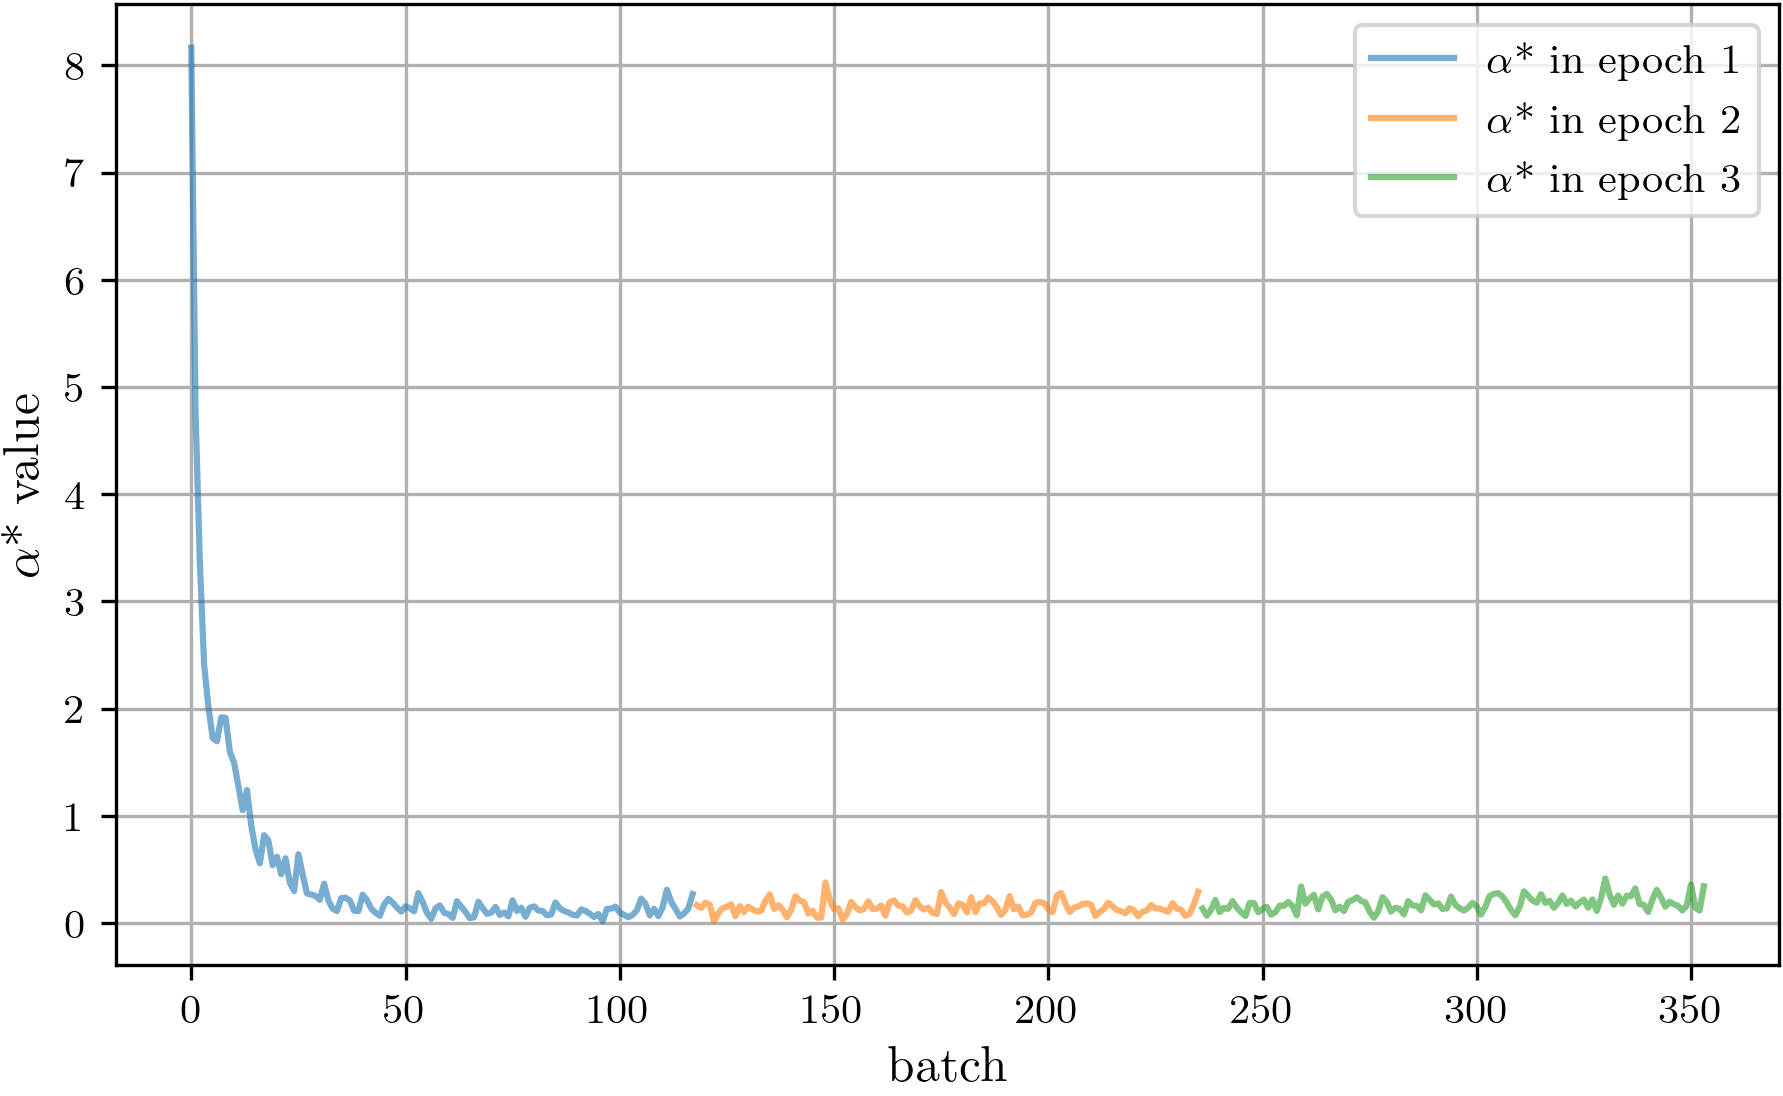

In [12]:



# plot_data(complete_avg_alphas,[], "large", "10 batches", "average alpha*", True, concat_data = True, legend_labels=["alpha* in epoch 1", "alpha* in epoch 2", "alpha* in epoch 3"])
plot_data(complete_alphas[:3], [], "large","batch" ,r'$\alpha$* value', use_legend=True, legend_labels=[r'$\alpha$* in epoch 1',
                                                                                                            r'$\alpha$* in epoch 2',
                                                                                                              r'$\alpha$* in epoch 3'], 
                                                                                                              concat_data= True, horizontal=False
                                                                                                              ,font_adj=1)

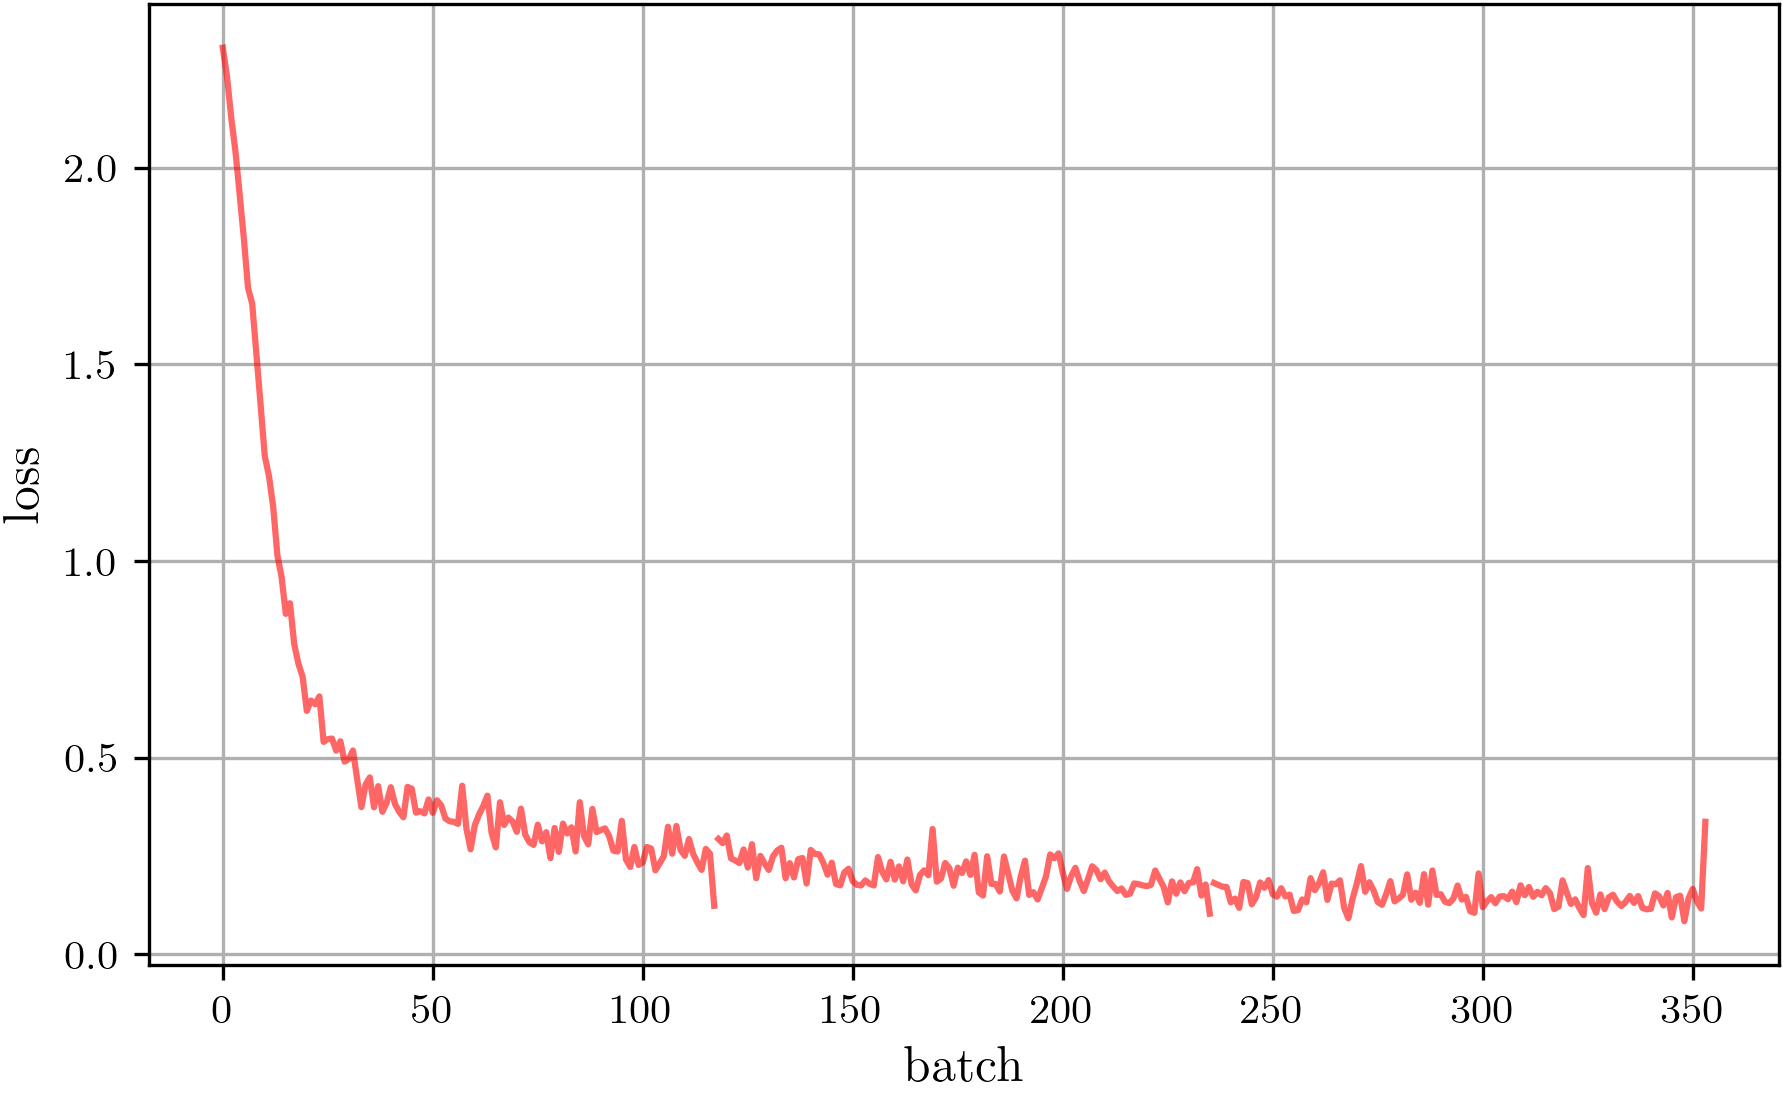

In [30]:
plot_data(complete_loss[:3],['r','r','r'], "small", "batch", "loss", concat_data = True, use_legend=False,font_adj=1,
          horizontal=False)

In [28]:
import numpy as np
import torch  # If you're using PyTorch tensors
                  # alpha values for epoch 3


def calculate_statistics(data):
    # Initialize lists to hold epoch-wise statistics
    epoch_means = []
    epoch_variances = []
    epoch_std_devs = []
    epoch_maximums = []
    epoch_minimums = []  # New list for epoch-wise minimums

    # Flatten the list of tensors into a single list and calculate epoch statistics
    all_values = []
    for epoch in data:
        # Create a list to hold the values for the current epoch
        epoch_values = []
        for value in epoch:
            # Convert scalar tensors to 1D arrays
            if value.dim() == 0:  # Check if it's a scalar tensor
                epoch_values.append(np.array([value.item()]))  # Convert scalar to 1D array
            else:
                epoch_values.append(value.detach().numpy())  # Convert to NumPy array

        # Now flatten the epoch_values list
        epoch_values = np.concatenate(epoch_values)

        # Calculate statistics for the current epoch
        epoch_means.append(np.mean(epoch_values))
        epoch_variances.append(np.var(epoch_values))
        epoch_std_devs.append(np.std(epoch_values))
        epoch_maximums.append(np.max(epoch_values))  # Calculate maximum for the epoch
        epoch_minimums.append(np.min(epoch_values))  # Calculate minimum for the epoch

        # Append the epoch values to the all_values list for overall statistics
        all_values.extend(epoch_values)

    # Convert all_values to a NumPy array for combined statistics
    all_values_np = np.array(all_values)

    # Calculate overall statistics
    combined_mean = np.mean(all_values_np)
    combined_variance = np.var(all_values_np)
    combined_std_dev = np.std(all_values_np)
    combined_maximum = np.max(all_values_np)  # Calculate maximum for all epochs combined
    combined_minimum = np.min(all_values_np)  # Calculate minimum for all epochs combined

    return {
        "combined": {
            "mean": combined_mean,
            "variance": combined_variance,
            "std_dev": combined_std_dev,
            "maximum": combined_maximum,  # Include maximum
            "minimum": combined_minimum   # Include minimum
        },
        "epoch": {
            "means": epoch_means,
            "variances": epoch_variances,
            "std_devs": epoch_std_devs,
            "maximums": epoch_maximums,    # Include maximums for each epoch
            "minimums": epoch_minimums      # Include minimums for each epoch
        }
    }

# Calculate statistics for each list
statistics = calculate_statistics(complete_avg_alphas)

# Print the results
print("Combined Statistics:")
print("Mean:", statistics["combined"]["mean"])
print("Variance:", statistics["combined"]["variance"])
print("Std Dev:", statistics["combined"]["std_dev"])
print("Maximum:", statistics["combined"]["maximum"])
print("Minimum:", statistics["combined"]["minimum"])  # Print minimum for combined

print("\nEpoch-wise Statistics:")
for i in range(len(statistics["epoch"]["means"])):
    print(f"Epoch {i + 1}: Mean:", statistics["epoch"]["means"][i],
          "Variance:", statistics["epoch"]["variances"][i],
          "Std Dev:", statistics["epoch"]["std_devs"][i],
          "Maximum:", statistics["epoch"]["maximums"][i],
          "Minimum:", statistics["epoch"]["minimums"][i])  # Print minimum for each epoch


Combined Statistics:
Mean: 0.2617445310408419
Variance: 0.21944389021584995
Std Dev: 0.46844838586107856
Maximum: 2.8222761154174805
Minimum: 0.0903460755944252

Epoch-wise Statistics:
Epoch 1: Mean: 0.45785255459221924 Variance: 0.5989440375604644 Std Dev: 0.773914748251036 Maximum: 2.8222761154174805 Minimum: 0.0903460755944252
Epoch 2: Mean: 0.14575354958122427 Variance: 0.0001807522483694231 Std Dev: 0.013444413277247286 Maximum: 0.1639009565114975 Minimum: 0.11793578416109085
Epoch 3: Mean: 0.18162748894908212 Variance: 0.0008758757239902066 Std Dev: 0.02959519765080488 Maximum: 0.21840429306030273 Minimum: 0.12991702556610107


In [10]:
# Print the lengths
print("Length of alpha_values_tensor:", len(alpha_values_tensor))
print("Length of avg_alpha_values_tensor:", len(avg_alpha_values_tensor))
print("Length of avg_loss_values_tensor:", len(avg_loss_values_tensor))
print(len(complete_alphas))  # expect n for n epochs
print(len(complete_loss))   
print(len(complete_avg_alphas))  
print(len(complete_avg_losses))

Length of alpha_values_tensor: 938
Length of avg_alpha_values_tensor: 86
Length of avg_loss_values_tensor: 86
3
3
3
3


In [12]:
def plot_results(complete_alphas, complete_losses):
    """ 
    Takes lists of alphas and losses for each epoch and plots them.
    """
    with plt.rc_context(jmlr_style):
        plt.figure()

        # Initialize the starting index for x-values
        start_index = 0
        
        # Plot alpha values for each epoch
        for epoch_idx, alphas in enumerate(complete_alphas):
            # Convert the current epoch alphas to numpy for plotting
            alphas_np = np.array([a.detach().numpy() for a in alphas])  # Detach if they're tensors
            
            # Create x-values for the current epoch
            x_values = np.arange(start_index, start_index + len(alphas_np))
            
            # Plot alpha values for the current epoch
            plt.plot(x_values, alphas_np, label=f'Alpha in Epoch {epoch_idx + 1}', alpha=0.6)
            
            # Update the starting index for the next epoch
            start_index += len(alphas_np)

        # Plot losses
        # losses_flattened = [loss for sublist in complete_losses for loss in sublist]
        # x_losses = np.arange(len(losses_flattened))  # x-values for losses
        # plt.plot(x_losses, losses_flattened, label='Loss', color='red', linewidth=2)

        # Adding details to the plot
        plt.xlabel("10 Batches")
        plt.ylabel(r'$\alpha$* Value')
        plt.axhline(0, color='black', lw=0.8, ls='--')  # Add a horizontal line at y=0 for reference
        plt.legend()
        plt.grid(True)
        # Adding explanation below the plot using figtext
        plt.savefig('plot.pdf')  # dpi=300 ensures good quality

    
        plt.show()

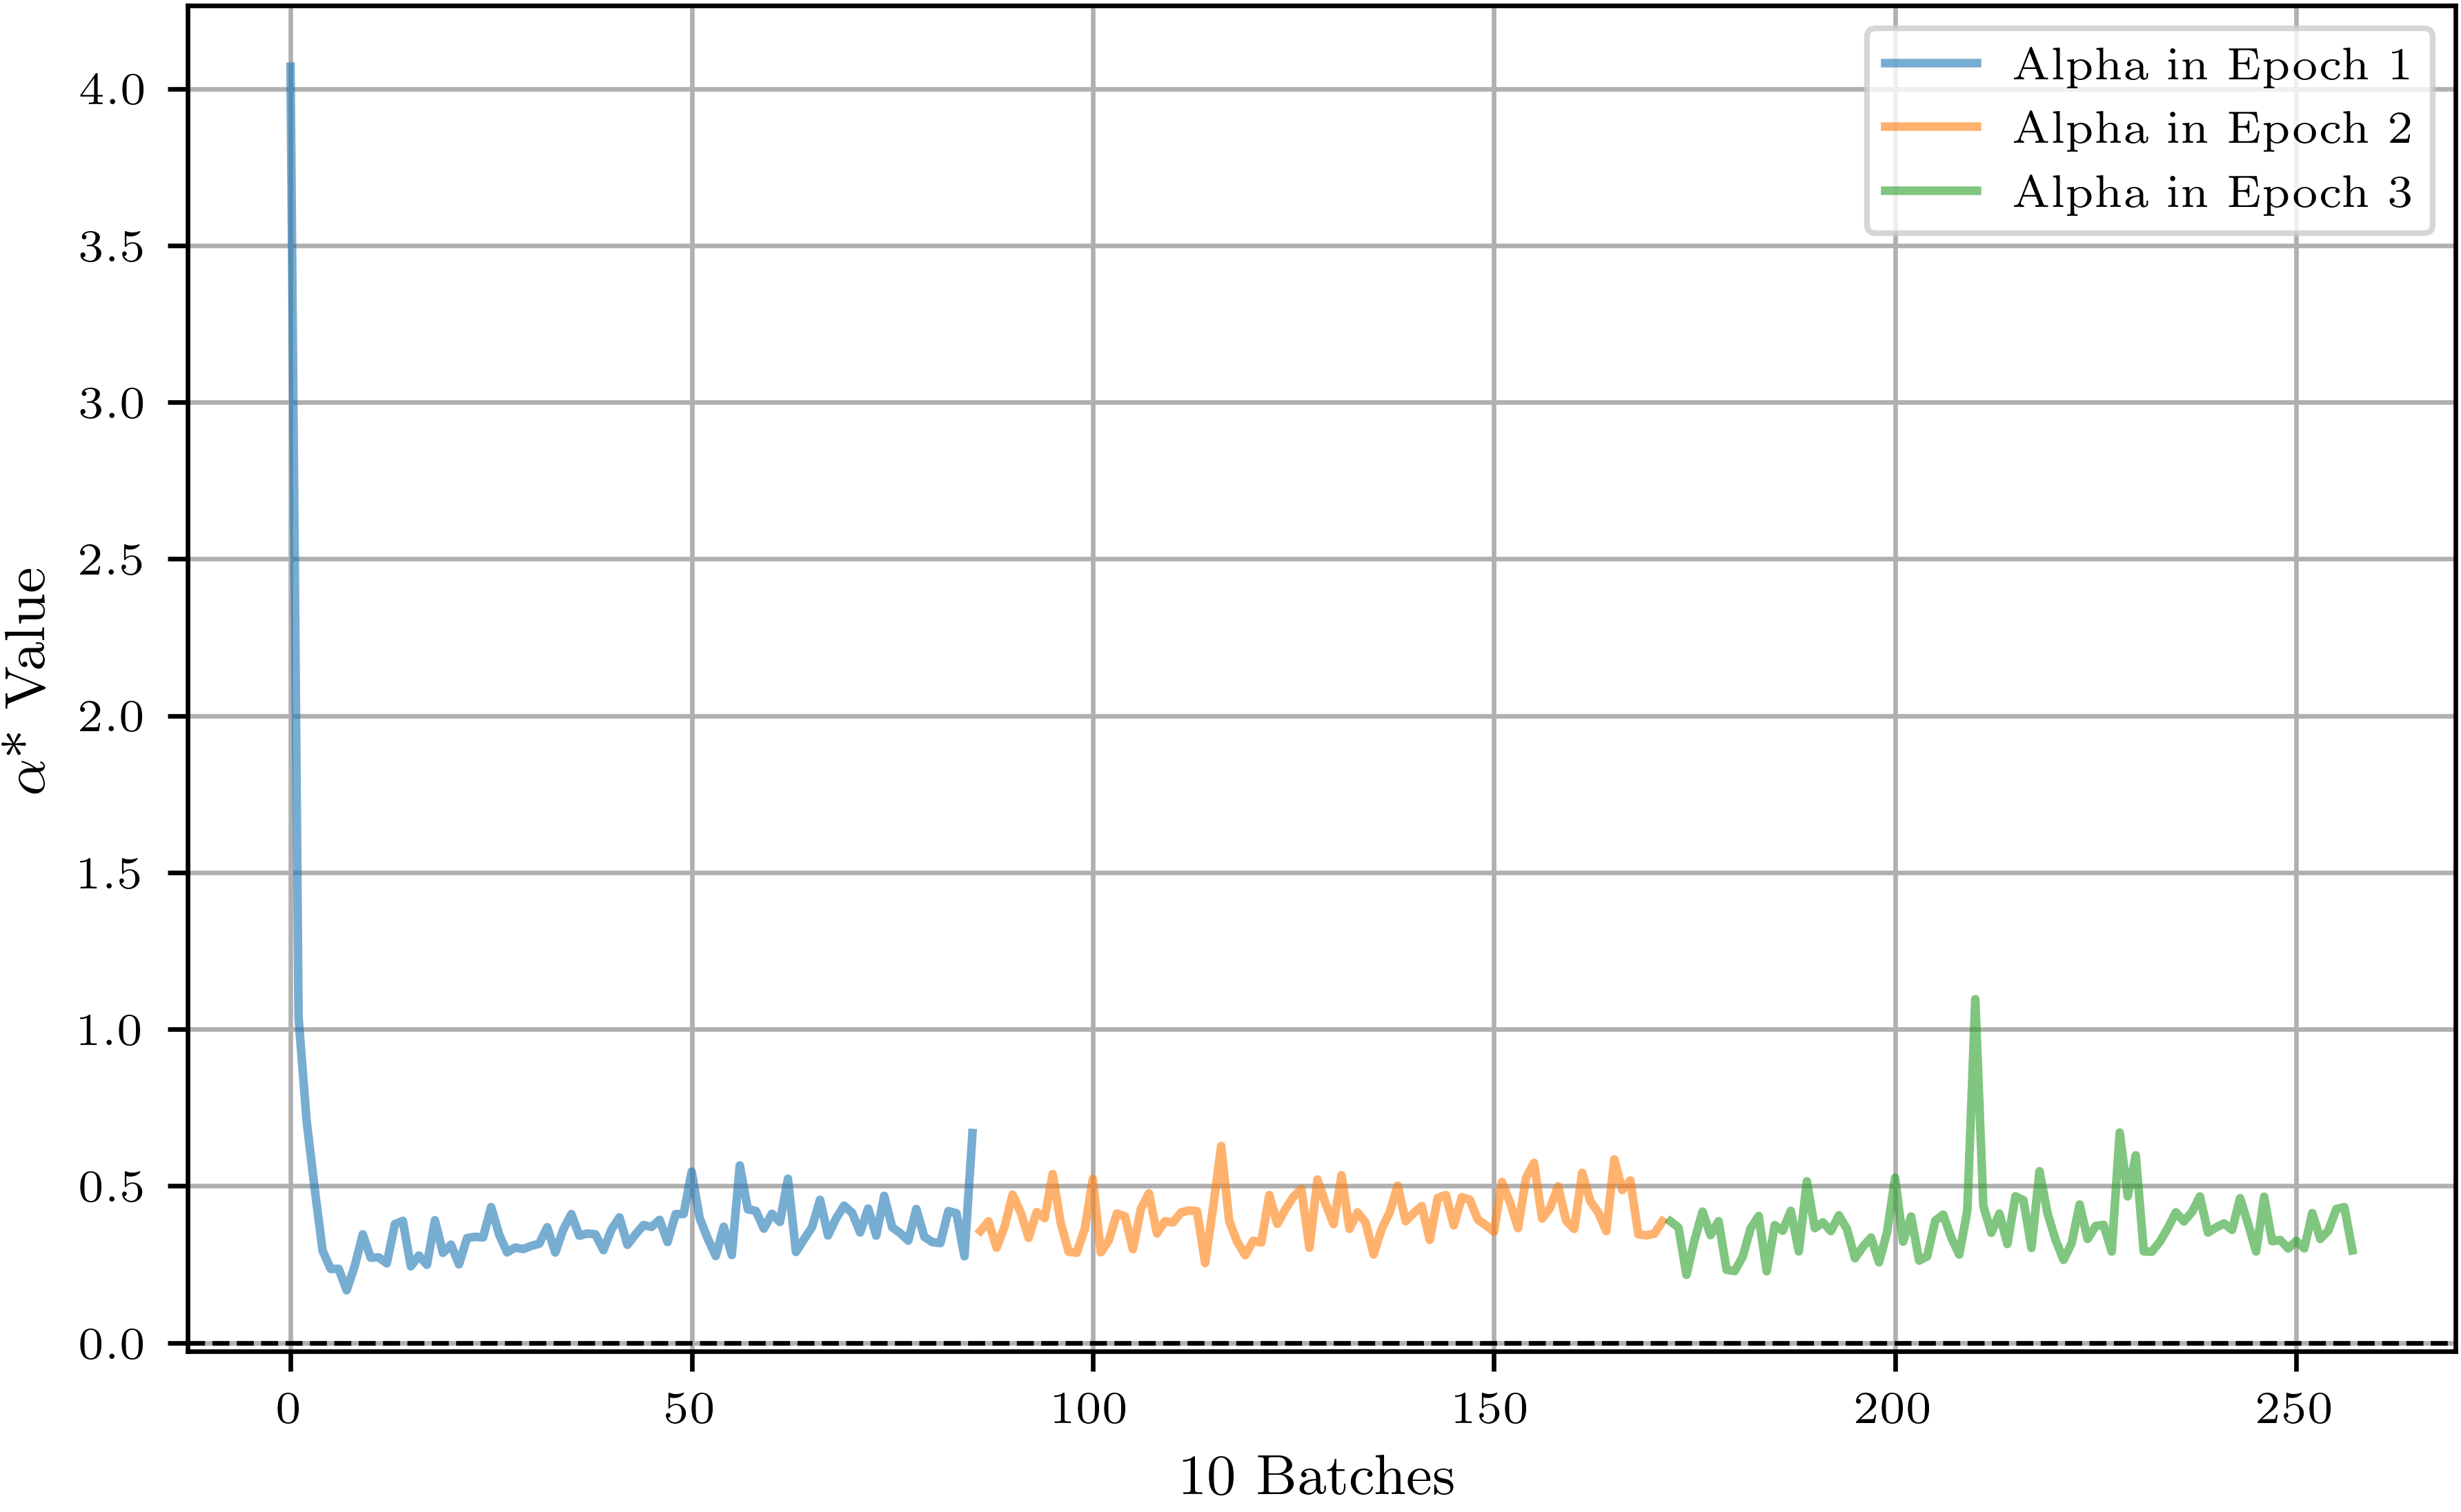

In [13]:
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 600})
plot_results(complete_avg_alphas, complete_avg_losses)
